In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import sys
%matplotlib inline

In [18]:
train_data = pd.read_csv('iris.data',header = None)


In [19]:
k = 3
distance = 'cityblock'
total_dist = 0

In [20]:
label = train_data.columns[-1]
classes = train_data[label].unique()
train_data["true code"] = train_data[label].astype('category')
train_data["true code"] = train_data["true code"].cat.codes

In [21]:
from sklearn.decomposition import PCA
x = train_data.drop(['true code',label],axis = 1)

In [22]:
def euclidean(datapoint,centroid):
    global total_dist
    final=[]
    for i in range(0,len(datapoint)):
        arr = []
        for k in range(len(centroid)):
            total_dist +=1
            val= ((math.sqrt(sum(np.square(float(a)-float(b)) for a,b in zip(datapoint.iloc[i],centroid[k])))))
            arr.append(val)
        final.append(np.argmin(arr))
    return final

In [23]:
def cityblock(datapoint,centroid):
    global total_dist
    final=[]
    for i in range(0,len(datapoint)):
        arr = []
        for k in range(len(centroid)):
            total_dist +=1
            val= sum(abs(a-b) for a,b in zip(datapoint.iloc[i],centroid[k]))
            arr.append(val)
        final.append(np.argmin(arr))
    return final

In [24]:
def cos_distance(datapoint,centroid):
    final=[]
    global total_dist
    for i in range(0,len(datapoint)):
        arr = []
        for k in range(len(centroid)):
                total_dist +=1
                additions = 0
                len_a = 0
                len_b = 0
                for a,b in zip(datapoint.iloc[i],centroid[k]):
                    dot_prod = a*b
                    additions += dot_prod
                    len_a += a*a
                    len_b += b*b
                len_a = np.sqrt(len_a)
                len_b = np.sqrt(len_b)
                cos = (additions)/((len_a)*(len_b))
                arr.append(1-cos)
        final.append(np.argmin(arr))
    return final

In [25]:
def equations(datapoint,centroid,type_eq):
    final1 = []
    final2 = []
    global total_dist
    for i in range(0,len(datapoint)):
        arr1 = []
        arr2 = []
        for k in range(len(centroid)): 
            total_dist +=1
            sum1 = 0
            sum2 = 0
            denom = 0
            for a,b in zip(datapoint.iloc[i],centroid[k]):
                dif = a-b
                term1 = max(dif,0)
                term2 = max(-dif,0)
                sum1+=term1
                sum2+=term2
                denom += max(abs(a),abs(b),abs(dif))
            sum1=sum1*sum1
            sum2=sum2*sum2
            total = math.sqrt(sum1+sum2)
            equ2 = total/denom
            arr1.append(total)
            arr2.append(equ2)
        final1.append(np.argmin(arr1))
        final2.append(np.argmin(arr2))
    if (type_eq=='equ1'):
        return final1
    else:
        return final2

In [26]:
def initial_random_centroids():
    columns = train_data.columns.drop(label)
    columns = columns.drop('true code')
    arrmax = []
    arrmin = []
    for each in columns:
        max = train_data[each].max()
        min = train_data[each].min()
        arrmax.append(max)
        arrmin.append(min)   
    initial_centroids = []
    for j in range(k):
        centroid=[]
        for i in range(len(columns)):
            centroid.append(np.random.randint(0,round(arrmax[i])))
        initial_centroids.append(centroid)
    return initial_centroids

In [27]:
def calc_centroid(data_points):
    return np.array(data_points.mean())


In [28]:
def initial_cluster(initial_centroids):
    if distance=='euclidean':
        train_data['cluster'] = euclidean(train_data.drop([label,'true code'],axis = 1),initial_centroids)
    elif distance=='cityblock':
        train_data['cluster'] = cityblock(train_data.drop([label,'true code'],axis = 1),initial_centroids)
    elif distance=='cos':    
        train_data['cluster'] = cos_distance(train_data.drop([label,'true code'],axis = 1),initial_centroids)
    elif distance == 'equation1':
        train_data['cluster'] = equations(train_data.drop([label,'true code'],axis = 1),initial_centroids,'equ1')
    elif distance == 'equation2':
        train_data['cluster'] = equations(train_data.drop([label,'true code'],axis = 1),initial_centroids,'equ2')
    else:
        print('please enter correct distance function: (euclidean/cityblock/cos/equation1/equation2)')
        sys.exit(0)        
    return initial_centroids

In [29]:
def find_centroids(train_data):
    centroids = []
    for i in range(k):
        centroids.append(calc_centroid(train_data[train_data["cluster"]==i].drop('cluster',axis = 1)))
    return centroids

In [30]:
def calc_best_centroid(train_data,centroids):
        old_clusters = np.array(train_data["cluster"])
        old_centroids = centroids
        new_centroids = centroids
        iterations = 0
        while True:
            iterations+=1
            if distance=='euclidean':
                new_clusters = euclidean(train_data.drop(["cluster",'true code'],axis = 1),new_centroids)
            elif distance=='cityblock':
                new_clusters = cityblock(train_data.drop(["cluster",'true code'],axis = 1),new_centroids)
            elif distance=='cos':
                new_clusters = cos_distance(train_data.drop(["cluster",'true code'],axis = 1),new_centroids)
            elif distance == 'equation1':
                new_clusters = equations(train_data.drop(["cluster",'true code'],axis = 1),new_centroids,'equ1')
            elif distance == 'equation2':
                new_clusters = equations(train_data.drop(["cluster",'true code'],axis = 1),new_centroids,'equ2')
            else:
                print('please enter correct distance function: (euclidean/cityblock/cos/equation1/equation2)')
                sys.exit(0)
            train_data['cluster'] = new_clusters 
            new_centroids = find_centroids(train_data.drop(['true code'],axis = 1))
            if np.array_equal(old_centroids,new_centroids):
                break
            else:
                old_centroids = new_centroids
                old_clusters = new_clusters
            #print ("total",total)
        sum_sq_errors = calc_sse(new_clusters,new_centroids)
        return new_clusters,new_centroids,iterations,sum_sq_errors
    



In [31]:
def calc_sse(y,centroids):
    sum = 0.0
    for i in range(k):
        for j in range(len(y)):
            if y[j] == i:
                diff = np.array(x.loc[j])-centroids[i]
                distance = np.linalg.norm(diff)
                sum += distance*distance
    return sum

Final Cluster for data-points [2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total Iteration: 6
Total Distance calculations: 2700
Sum of Squared errors: 142.928508941


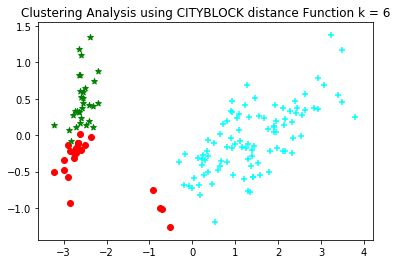

In [32]:
iterations = 0
sum_sq_errors = 0
while True:
    initial_centroids = initial_random_centroids()
    initial_cluster(initial_centroids)
    centroids = find_centroids(train_data.drop(['true code',label],axis = 1))
    if not(np.isnan(centroids).any()):
        break
    else:
        train_data = train_data.drop('cluster', axis = 1)
        
total_dist = 0

y,final_centroids,iterations,sum_sq_errors = calc_best_centroid(train_data.drop(label,axis = 1),centroids)
#y = train_data['true code']

print ('Final Cluster for data-points',y)
print ('Total Iteration:',iterations)
print ('Total Distance calculations:',total_dist)
print ('Sum of Squared errors:',sum_sq_errors)

pca = PCA(n_components=2).fit(x)
pca_2d = pca.transform(x)
import pylab as pl
for i in range(0, pca_2d.shape[0]):
    if y[i] == 0:
       c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='cyan',marker='+')
    elif y[i] == 1:
       c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif y[i] == 2:
       c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='*')
    elif y[i] == 3:
       c4 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
    elif y[i] == 4:
       c5 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='y',marker='*')
    elif y[i] == 5:
       c6 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='pink',marker='o')
    elif y[i] == 6:
       c7 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='black',marker='*')
    elif y[i] == 7:
       c8 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='y',marker='o')
    elif y[i] == 8:
       c9 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='purple',marker='*')
    elif y[i] == 9:
       c10 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='cyan',marker='*')
#pl.title('Original Glass Data set')    
pl.title('Clustering Analysis using CITYBLOCK distance Function k = 6')
pl.show()